In [10]:
import pandas as pd
import numpy as np
from field_importer import get_field
import pickle
from cartoplot import cartoplot
import mask
from tqdm import trange
from math import sin, cos, sqrt, radians
import os
from mask import select_region
import xarray as xr
from netCDF4 import Dataset
import numpy.ma as ma
import matplotlib.pyplot as plt
import regrid

In [11]:
yearlist = list(range(2019,2021))
print(yearlist)
resolution = (361,361)

monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_start = ["03","04","10","11","12"]
monthlist_end = ["01","02","03"]

mW99 = {"depth":{},"density":{},"SWE":{}}

for year in yearlist:
    
    print(year)
    
    #########################################
    
    # DECIDE WHICH ICE TYPE DATA TO USE
    
    type_data = 'cds'
        
    ##########################################
    
    # DON'T CONSIDER PERIOD BEFORE ENVISAT LAUNCH
    
    if year == 2002:
        
        monthlist = monthlist_start
        
    else:
        
        monthlist = monthlist_full
    
    # Make some empty arrays and fill with nans

    mW99['depth'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
    mW99['density'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
    mW99['SWE'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
        
        
    ###########################################
    
    for counter, month in enumerate(monthlist):
        
        # Get W99 data for that month
        
        W99 = {}
        
        W99['depth'] = get_field('W99', month = month, year = year, 
                              variable='depth', resolution = 361)['field']

        
        W99['SWE'] = get_field('W99', month = month, year = year,
                              variable='SWE', resolution = 361)['field']
        
        
        W99['density'] = np.divide(W99['SWE'],W99['depth'])
        
        # Get OSISAF type data

        ice_type = get_field(type_data,
                                 month,
                                 year,
                                 resolution=361,
                                 variable='Sea_Ice_Type')['field']
        
        # MASK ARRAYS WHERE ICE TYPE IS OPEN WATER OR UNKNOWN
        
        for variable in ['depth', 'SWE', 'density']:
            
            ### Flatten mW99 ####
#             m = select_region('basin',W99[variable])

#             basin_mean = np.nanmean(m)
#             W99[variable] = ma.masked_where(~np.isnan(W99[variable]), W99[variable])
#             W99[variable] = np.ma.filled(W99[variable].astype(float), basin_mean)
        
            W99[variable] = ma.masked_where(ice_type < 2, W99[variable])
            W99[variable] = np.ma.filled(W99[variable].astype(float), np.nan)
            
            

        
        # CREATE FYI MASK OF 1 EVERYWHERE APART FROM 0.5 OVER FYI
        
        FYI = ma.masked_where(ice_type != 2, np.full((resolution),0.5))
        FYI = np.ma.filled(FYI.astype(float), 1)
        
        mW_depth = np.multiply(FYI,W99['depth'])
        mW_SWE = np.multiply(FYI,W99['SWE'])

        
        # Now clean the data where negative snow depths and swe's occur
        

        mW_depth_clean = ma.masked_where(mW_depth <0, mW_depth)
        mW_depth_clean = np.ma.filled(mW_depth_clean.astype(float), 0)
        
        mW_SWE_clean = ma.masked_where(mW_SWE <0, mW_SWE)
        mW_SWE_clean = np.ma.filled(mW_SWE_clean.astype(float), 0)
        
        
        # Put final data into dictionary ready for output

        mW99['depth'][counter] = mW_depth_clean
        mW99['density'][counter] = W99['density']
        mW99['SWE'][counter] = mW_SWE_clean
    
    # SAVE THE YEAR'S DATA AS NETCDF
    
    monthlist_ints = []
    for i in monthlist:
        monthlist_ints.append(int(i))
    
    ds = xr.Dataset( data_vars={'depth':(['t','x','y'],mW99['depth']),
                                'density':(['t','x','y'],mW99['density']),
                                'SWE':(['t','x','y'],mW99['SWE'])},
                    
                         coords={'lon':(['x','y'],mask.get('lon')),
                                 'lat':(['x','y'],mask.get('lat')),
                                 'month':(['t'],monthlist_ints)})
    
    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/W99/mW99_361/'
    
    ds.to_netcdf(f'{data_dir}{year}_mW99.nc','w')
    
    # GET THIS DATA WITH ds_month = ds.where(10 == ds.month, drop=True)

[2019, 2020]
2019
2020


In [13]:
%config Completer.use_jedi = False

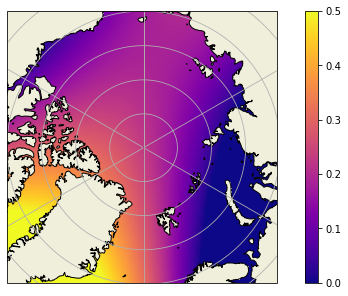

In [23]:
flat_data = get_field('mw99_flat',month="10",year=2012,variable='depth',resolution=361)

norm_data = get_field('w99',month="10",year=2012,variable='depth',resolution=361)

new_data = norm_data['field']-flat_data['field']

new_data = flat_data['field']-norm_data['field']

cartoplot(data['lon'],data['lat'],norm_data['field'],
          color_scale=(0,0.5),
          bounding_lat=70
         )

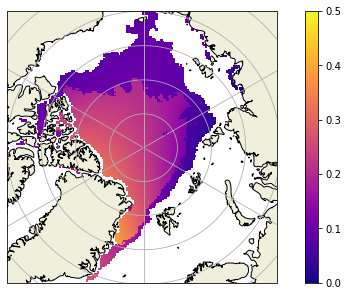

In [24]:
flat_data = get_field('mw99_flat',month="10",year=2012,variable='depth',resolution=361)

norm_data = get_field('mw99',month="10",year=2012,variable='depth',resolution=361)

new_data = norm_data['field']-flat_data['field']

new_data = flat_data['field']-norm_data['field']

cartoplot(data['lon'],data['lat'],norm_data['field'],
          color_scale=(0,0.5),
          bounding_lat=70
         )

# Test the dataset

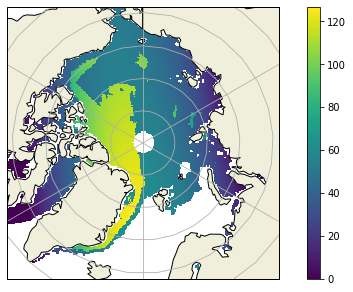

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


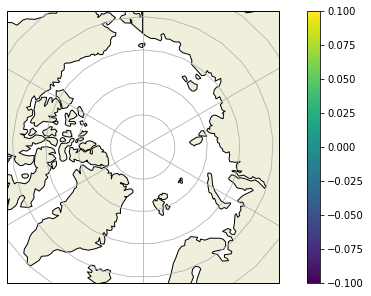

[]


In [13]:
d = get_field('mw99',year=2012,month="04",variable='SWE',resolution=361)

cartoplot(d['lon'],d['lat'],d['field'])

masked = ma.masked_where(d['field'] >= 0, d['field'])
masked = np.ma.filled(masked.astype(float), np.nan)

cartoplot(d['lon'],d['lat'],masked)

serial_data = masked.ravel()

not_nan_array = ~ np.isnan(serial_data)

clean_array = serial_data[not_nan_array]

print(clean_array)